In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
# url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR30F8lYP3jG7YOq8es0PBpJIE5yvRVZffOyaqC0GgMBN6yt0Q-NI8pxS7hd1F9dYXnowSC6zpZmW9D/pubhtml'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
# soup =BeautifulSoup(content, 'lxml')

In [5]:
# data = soup.findAll(text=re.compile("Last update: .+"))
# data

In [6]:
# m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
# data_date_time = ' '.join([m.group(1), m.group(2)])
# data_date_time = re.sub("[\.]","",data_date_time)
# data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
# data_date_time
data_date_time = datetime.now().strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-03-16 11:09'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)
dfs[0]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1,Currently being updated,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CASES,DEATHS,DEATHS,RECOVERED,RECOVERED,UNRESOLVED,UNRESOLVED,NaN
3,4,171851,6642,6642,77494,77494,87715,87715,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
135,136,Gibraltar,1,0,1,NaN,NaN,Source,NaN
136,137,Vatican City,1,0,NaN,NaN,NaN,Source,NaN
137,138,Queue,590,NaN,NaN,NaN,NaN,NaN,NaN
138,139,TOTAL,171851,6642,5447,108,77494,NaN,NaN


### International

In [9]:
df_intl=dfs[0]
df_intl  = df_intl.drop(df_intl .columns[0], axis=1)
df_intl  = df_intl.drop(list(range(6)), axis=0)
num_cols = len(df_intl.columns)
columns = ['d'] * num_cols
columns[0]='international'
columns[1]='cases'
df_intl.columns=columns
df_intl



,international,cases,d,d,d,d,d,d
6,China,80860,3213,3032,-,67490,Source,NaN
7,Italy,24747,1809,1672,-,2335,Source,NaN
8,Iran,14991,853,-,-,4996,Source,NaN
9,South Korea,8236,75,-,36,1137,Source,NaN
10,Spain,7844,292,272,-,517,Source,NaN
...,...,...,...,...,...,...,...,...
135,Gibraltar,1,0,1,NaN,NaN,Source,NaN
136,Vatican City,1,0,NaN,NaN,NaN,Source,NaN
137,Queue,590,NaN,NaN,NaN,NaN,NaN,NaN
138,TOTAL,171851,6642,5447,108,77494,NaN,NaN


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)
df_intl = df_intl.dropna(0, how='all')

#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases.drop(columns = ['China', 'Queue', 'TOTAL'], inplace=True)
df_intl_cases


international,Italy,Iran,South Korea,Spain,France,Germany,United States,United Kingdom,Switzerland,Netherlands,...,Congo Republic,Sudan,Mauritania,Central African Republic,Guinea,Togo,Nepal,Bhutan,Gibraltar,Vatican City
cases,24747,14991,8236,7844,5423,5813,3791,1372,2200,1135,...,1,1,1,1,1,1,1,1,1,1


In [12]:
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [re.sub('[^\d]+', '', x)  for x in row ])
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(x) if x!='' else 0  for x in row ])

In [13]:
df_intl_cases

international,Italy,Iran,South Korea,Spain,France,Germany,United States,United Kingdom,Switzerland,Netherlands,...,Congo Republic,Sudan,Mauritania,Central African Republic,Guinea,Togo,Nepal,Bhutan,Gibraltar,Vatican City
cases,24747,14991,8236,7844,5423,5813,3791,1372,2200,1135,...,1,1,1,1,1,1,1,1,1,1


In [14]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
df_intl_cases

international,datetime,Italy,Iran,South Korea,Spain,France,Germany,United States,United Kingdom,Switzerland,...,Congo Republic,Sudan,Mauritania,Central African Republic,Guinea,Togo,Nepal,Bhutan,Gibraltar,Vatican City
cases,2020-03-16 11:09,24747,14991,8236,7844,5423,5813,3791,1372,2200,...,1,1,1,1,1,1,1,1,1,1


In [15]:
# some assertion to ensure data quality
assert int(df_intl_cases['South Korea'])>6000

#### Save to file

In [16]:
from pathlib import Path
csv_file = '../data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)

    df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [17]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Afghanistan,Albania,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,Turkey,UAE,Ukraine,United Arab Emirates,United Kingdom,United States,Uzbekistan,Vatican City,Venezuela,Vietnam
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,0,0,0,0,0,0,15,0,0,0,...,0,5,0,0,2,12,0,0,0,12
2020-02-06 08:19,0,0,0,0,0,0,15,0,0,0,...,0,5,0,0,3,12,0,0,0,12
2020-02-06 09:01,0,0,0,0,0,0,15,0,0,0,...,0,5,0,0,3,12,0,0,0,12
2020-02-06 09:46,0,0,0,0,0,0,15,0,0,0,...,0,5,0,0,3,12,0,0,0,12
2020-02-06 17:56,0,0,0,0,0,0,15,0,0,0,...,0,5,0,0,3,12,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-16 07:11,20,38,49,1,56,20,353,860,19,214,...,12,0,3,98,1372,3791,4,1,17,57
2020-03-16 08:09,21,42,49,1,56,30,353,860,25,214,...,18,0,3,98,1372,3791,4,1,17,57
2020-03-16 09:10,21,42,49,5,56,30,353,860,25,221,...,18,0,3,98,1372,3791,6,1,17,57


In [18]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-03-16 11:09')

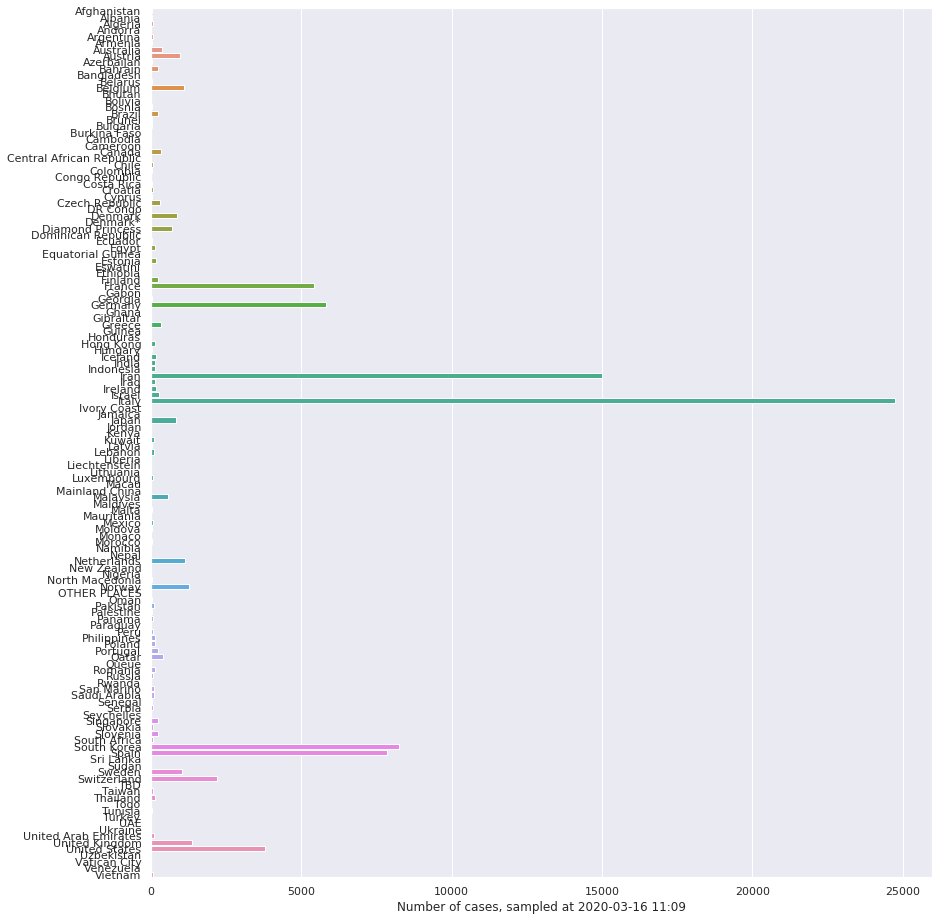

In [19]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,16)})
ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)



In [20]:
png_file='../images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)